# Using the SageMaker TensorFlow Serving Container

The [SageMaker TensorFlow Serving Container](https://github.com/aws/sagemaker-tensorflow-serving-container) makes it easy to deploy trained TensorFlow models to a SageMaker Endpoint without the need for any custom model loading or inference code.

## Setup

First, we need to ensure we have an up-to-date version of the SageMaker Python SDK, and install a few
additional python packages.

In [1]:
!pip install -U --quiet "sagemaker>=1.14.2"
!pip install -U --quiet opencv-python tensorflow-hub

You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 19.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


Next, we'll get the IAM execution role from our notebook environment, so that SageMaker can access resources in your AWS account later in the example.

In [2]:
from sagemaker import get_execution_role

sagemaker_role = get_execution_role()

## Download and prepare a model from TensorFlow Hub

The TensorFlow Serving Container works with any model stored in TensorFlow's [SavedModel format](https://www.tensorflow.org/guide/saved_model). This could be the output of your own training job or a model trained elsewhere. For this example, we will use a pre-trained version of the MobileNet V2 image classification model from [TensorFlow Hub](https://tfhub.dev/).

The TensorFlow Hub models are pre-trained, but do not include a serving ``signature_def``, so we'll need to load the model into a TensorFlow session, define the input and output layers, and export it as a SavedModel. There is a helper function in this notebook's `sample_utils.py` module that will do that for us.

In [31]:
import sample_utils

model_name = 'oxford_flowers_vgg_transfer'
export_path = 'flowers_vgg'
model_path = 'oxford-flowers-model/oxford_flowers_vgg_transfer/00000001/'

print('oxford flower model exported to {}'.format(model_path))

oxford flower model exported to oxford-flowers-model/oxford_flowers_vgg_transfer/00000001/


After exporting the model, we can inspect it using TensorFlow's ``saved_model_cli`` command. In the command output, you should see 

```
MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
...
```

The command output should also show details of the model inputs and outputs.

In [32]:
!saved_model_cli show --all --dir {model_path}


MetaGraphDef with tag-set: 'serve' contains the following SignatureDefs:

signature_def['serving_default']:
  The given SavedModel SignatureDef contains the following input(s):
    inputs['images'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 200, 200, 3)
        name: vgg16_input_1:0
  The given SavedModel SignatureDef contains the following output(s):
    outputs['scores'] tensor_info:
        dtype: DT_FLOAT
        shape: (-1, 102)
        name: dense_1_1/Softmax:0
  Method name is: tensorflow/serving/predict


Next we need to create a model archive file containing the exported model.

## Create a model archive file

SageMaker models need to be packaged in `.tar.gz` files. When your endpoint is provisioned, the files in the archive will be extracted and put in `/opt/ml/model/` on the endpoint. 

In [33]:
!tar -C "$PWD" -czf flowers.tar.gz oxford-flowers-model/

## Upload the model archive file to S3

We now have a suitable model archive ready in our notebook. We need to upload it to S3 before we can create a SageMaker Model that. We'll use the SageMaker Python SDK to handle the upload.

In [34]:
#from sagemaker.session import Session

model_data = Session().upload_data(path='flowers.tar.gz', key_prefix='model')
print('model uploaded to: {}'.format(model_data))

INFO:sagemaker:Created S3 bucket: sagemaker-us-east-1-354362171010


model uploaded to: s3://sagemaker-us-east-1-354362171010/model/flowers.tar.gz


## Create a SageMaker Model and Endpoint

Now that the model archive is in S3, we can create a Model and deploy it to an 
Endpoint with a few lines of python code:

In [35]:
from sagemaker.tensorflow.serving import Model

# Use an env argument to set the name of the default model.
# This is optional, but recommended when you deploy multiple models
# so that requests that don't include a model name are sent to a 
# predictable model.
env = {'SAGEMAKER_TFS_DEFAULT_MODEL_NAME': 'oxford_flowers_vgg_transfer'}

model = Model(model_data=model_data, role=sagemaker_role, framework_version=1.12, env=env)
predictor = model.deploy(initial_instance_count=1, instance_type='ml.t2.medium')

INFO:sagemaker:Creating model with name: sagemaker-tensorflow-serving-2019-02-12-10-19-22-967
INFO:sagemaker:Creating endpoint with name sagemaker-tensorflow-serving-2019-02-12-10-19-22-967


---------------------------------------------------------------!

## Make predictions using the endpoint

The endpoint is now up and running, and ready to handle inference requests. The `deploy` call above returned a `predictor` object. The `predict` method of this object handles sending requests to the endpoint. It also automatically handles JSON serialization of our input arguments, and JSON deserialization of the prediction results.

We'll use these sample images:

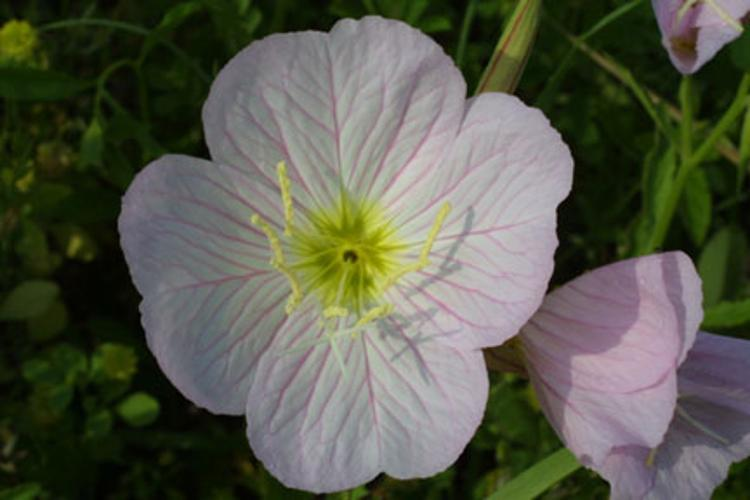

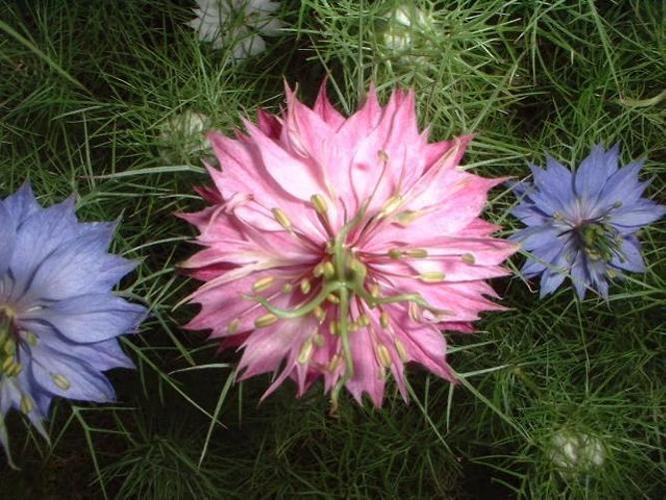

In [49]:
from IPython.display import display, Image
flower1 = '/tmp/data/train/0/image_06736.jpg'
flower2 = '/tmp/data/train/32/image_06443.jpg'
display(Image(filename=flower1))
display(Image(filename=flower2))

In [ ]:
!ls /tmp/data/train

In [38]:
# read the image files into a tensor (numpy array)
import importlib
importlib.reload(sample_utils)
flower01_image = sample_utils.image_file_to_tensor(flower1)
print(flower01_image.shape)

(1, 200, 200, 3)


In [ ]:
from sagemaker.tensorflow.serving import Predictor

predictor2 = Predictor(predictor.endpoint, model_name='oxford_flowers_vgg_transfer')

In [39]:
# get a prediction from the endpoint
# the image input is automatically converted to a JSON request.
# the JSON response from the endpoint is returned as a python dict
result = predictor.predict(flower01_image)

# show the raw result
print(result)

{'predictions': [[0.119748, 0.00987795, 0.00105149, 0.00355423, 0.00272996, 0.00676775, 0.0113991, 0.00163323, 0.0129666, 0.0102334, 0.00559307, 0.0176469, 0.0182917, 0.00380456, 0.00356788, 0.000255054, 0.000419484, 0.000845946, 0.0021758, 0.00104916, 0.00788278, 0.000172714, 0.00130065, 0.00110943, 0.00387784, 0.00361344, 0.00431109, 0.00235758, 0.000326709, 0.0187023, 0.00112309, 0.00873712, 0.000173241, 0.000694702, 0.00514667, 0.00265026, 0.0126432, 0.0143376, 0.000939815, 0.00107751, 0.0117138, 0.00721326, 0.00515768, 0.00475345, 0.024118, 0.00949905, 0.00266916, 0.000511342, 0.00333656, 0.0493599, 0.0630454, 0.00330822, 0.00185602, 0.00589587, 0.000730702, 0.014889, 0.00442235, 0.00686183, 0.00489469, 0.00195385, 0.0159099, 0.00678178, 0.0150771, 0.0117893, 0.00231261, 0.011134, 0.00439119, 0.0325844, 0.00621908, 0.000188842, 0.00485893, 0.0100741, 0.0165058, 0.0036891, 0.00237023, 0.0286739, 0.0100456, 0.00441786, 0.000525844, 0.0059348, 0.00117239, 0.00916347, 0.0126134, 0.048

In [48]:
max(result['predictions'][0])
for i, j in enumerate(result['predictions'][0]):
    if j == 0.119748:
        print(i)

0


In [52]:
flower02_image = sample_utils.image_file_to_tensor(flower2)
result = predictor.predict(flower02_image)
max(result['predictions'][0])

0.387205

In [53]:
for i, j in enumerate(result['predictions'][0]):
    if j == 0.387205:
        print(i) # wrong

28


### Add class labels and show formatted results

The `sample_utils` module includes functions that can add Imagenet class labels to our results and print formatted output. Let's use them to get a better sense of how well our model worked on the input image.

In [41]:
!ls /tmp/fastai-images/oxford-102-flowers/

jpg  test.txt  train.txt  valid.txt


In [30]:
# add class labels to the predicted result
sample_utils.add_imagenet_labels(result)

# show the probabilities and labels for the top predictions
sample_utils.print_probabilities_and_labels(result)

0.7799250 n02206856 bee
0.0632761 n11939491 daisy
0.0234317 n02219486 ant, emmet, pismire



## Additional Information

The TensorFlow Serving Container supports additional features not covered in this notebook, including support for:

- TensorFlow Serving REST API requests, including classify and regress requests
- CSV input
- Other JSON formats

For information on how to use these features, refer to the documentation in the 
[SageMaker Python SDK](https://github.com/aws/sagemaker-python-sdk/blob/master/src/sagemaker/tensorflow/deploying_tensorflow_serving.rst).

## Cleaning up

To avoid incurring charges to your AWS account for the resources used in this tutorial, you need to delete the SageMaker Endpoint.

In [ ]:
predictor.delete_endpoint()